
🧪 Running experiment: Low Trust

================= 🕒 Step 0 =================
👑 Leader 0 promotes with influence=0.77
🧍‍♀️ Consumer 351 | Leader 0 | Trust=0.55 | Sens=0.35 | Infl=0.77 | Prob=0.78 | Buy=False
🧍‍♀️ Consumer 188 | Leader 0 | Trust=0.50 | Sens=0.53 | Infl=0.77 | Prob=0.65 | Buy=False
🧍‍♀️ Consumer 278 | Leader 0 | Trust=0.34 | Sens=0.99 | Infl=0.77 | Prob=0.24 | Buy=False
🧍‍♀️ Consumer 461 | Leader 0 | Trust=0.49 | Sens=0.93 | Infl=0.77 | Prob=0.39 | Buy=False
🧍‍♀️ Consumer 330 | Leader 0 | Trust=0.47 | Sens=0.51 | Infl=0.77 | Prob=0.63 | Buy=True
🧍‍♀️ Consumer 183 | Leader 0 | Trust=0.38 | Sens=0.80 | Infl=0.77 | Prob=0.37 | Buy=False
🧍‍♀️ Consumer 31 | Leader 0 | Trust=0.47 | Sens=0.78 | Infl=0.77 | Prob=0.47 | Buy=False
🧍‍♀️ Consumer 203 | Leader 0 | Trust=0.33 | Sens=0.66 | Infl=0.77 | Prob=0.40 | Buy=False
🧍‍♀️ Consumer 141 | Leader 0 | Trust=0.49 | Sens=0.48 | Infl=0.77 | Prob=0.67 | Buy=True
🧍‍♀️ Consumer 97 | Leader 0 | Trust=0.43 | Sens=0.90 | Infl=0.77 | Prob=0.

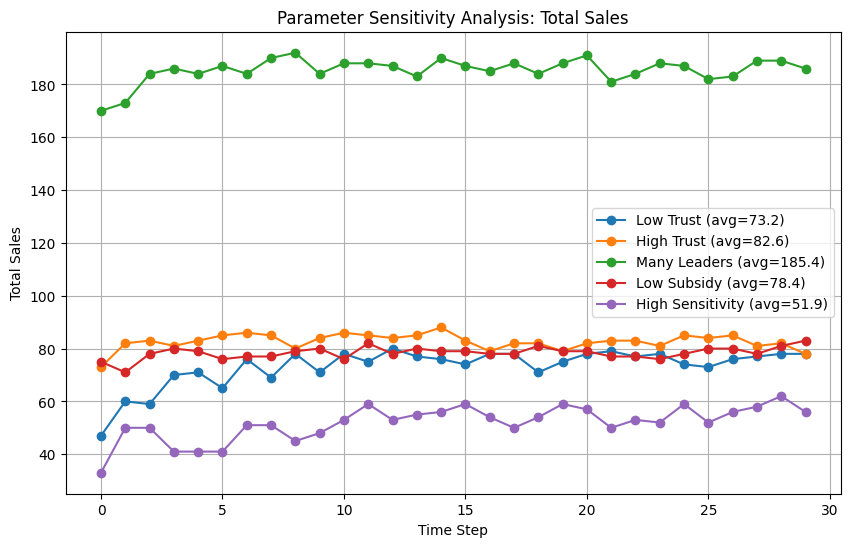

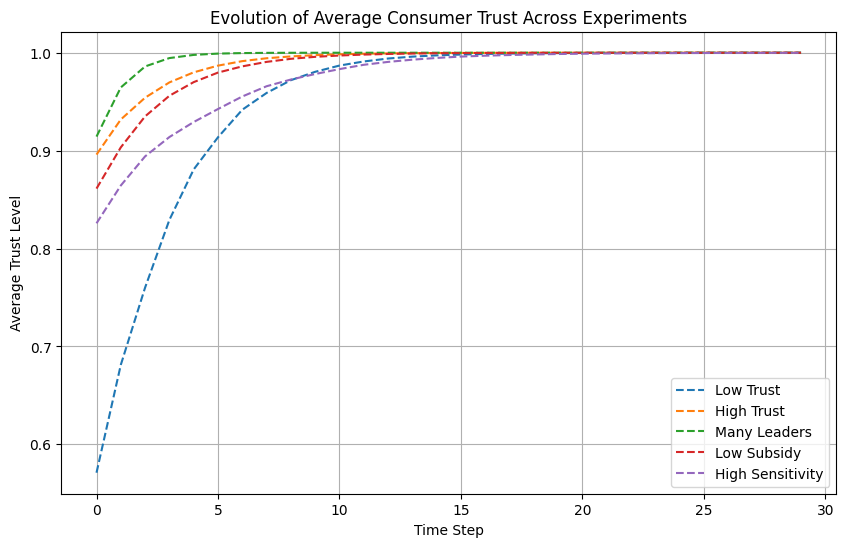

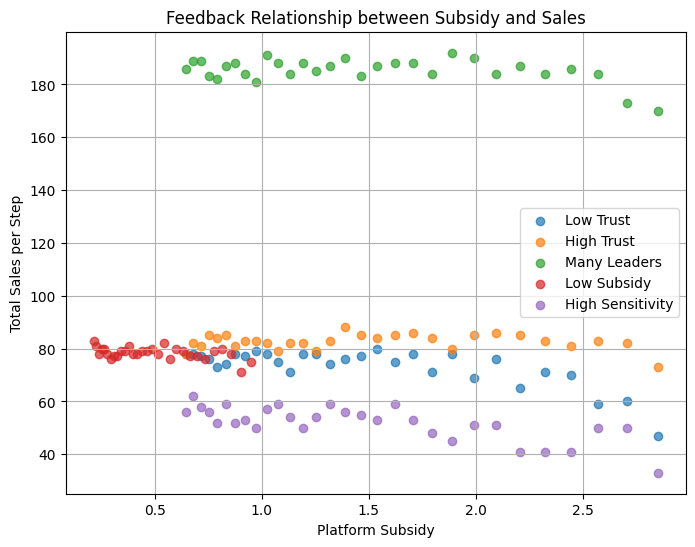

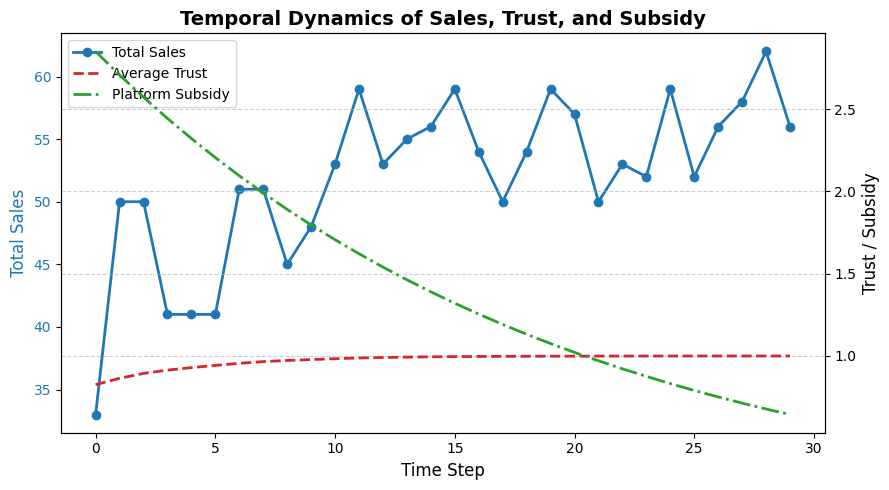

📁 Extended results saved to: /Users/estherwang/Documents/GitHub/4403_project/data/extended_sensitivity_results.csv


,Experiment,Average Sales,Final Trust,Final Subsidy
0,Low Trust,73.200000,0.999992,0.643916
1,High Trust,82.633333,0.999999,0.643916
2,Many Leaders,185.400000,1.000000,0.643916
3,Low Subsidy,78.366667,0.999998,0.214639
4,High Sensitivity,51.933333,0.999913,0.643916


In [1]:
# =============================================
# 📘 Parameter Sensitivity Analysis (Final Version)
# =============================================

import sys, os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- 导入模型模块 ---
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from model import GroupBuyingModel

# 固定随机种子以便复现
random.seed(42)
np.random.seed(42)

# ============================================================
# 🧠 参数敏感性实验设置
# ============================================================

experiments = [
    {"name": "Low Trust", "trust_range": (0.3, 0.6), "price_range": (0.3, 1.0), "leaders": 3, "subsidy": 3},
    {"name": "High Trust", "trust_range": (0.7, 1.0), "price_range": (0.3, 1.0), "leaders": 3, "subsidy": 3},
    {"name": "Many Leaders", "trust_range": (0.6, 1.0), "price_range": (0.3, 1.0), "leaders": 8, "subsidy": 3},
    {"name": "Low Subsidy", "trust_range": (0.6, 1.0), "price_range": (0.3, 1.0), "leaders": 3, "subsidy": 1},
    {"name": "High Sensitivity", "trust_range": (0.6, 1.0), "price_range": (1.0, 2.0), "leaders": 3, "subsidy": 3}
]

results = []

# ============================================================
# 🚀 运行实验
# ============================================================

for exp in experiments:
    print(f"\n==========================")
    print(f"🧪 Running experiment: {exp['name']}")
    print(f"==========================")

    # --- 定义自定义模型（带信任度与补贴追踪） ---
    class CustomModel(GroupBuyingModel):
        def __init__(self):
            from agents import Consumer, Leader, Platform
            from scheduler import SocialScheduler

            # 当样本量足够大时，局部波动会被平均化，宏观趋势更接近理论曲线。
            n_consumers = 500
            n_leaders = exp["leaders"]
            self.consumers = [
                Consumer(i, random.uniform(*exp["trust_range"]), random.uniform(*exp["price_range"]), list(range(n_consumers)))
                for i in range(n_consumers)
            ]
            self.leaders = [
                Leader(i, random.uniform(0.5, 1.0), random.sample(range(n_consumers), min(30, n_consumers)))
                for i in range(n_leaders)
            ]
            self.platform = Platform(base_price=5, subsidy=exp["subsidy"])
            self.scheduler = SocialScheduler(self.consumers, self.leaders, self.platform)
            self.sales_record, self.avg_trust_record, self.subsidy_record = [], [], []

        def step(self):
            total_sales = self.scheduler.step()
            self.sales_record.append(total_sales)
            avg_trust = np.mean([c.trust for c in self.consumers])
            self.avg_trust_record.append(avg_trust)
            self.subsidy_record.append(self.platform.subsidy)

    # --- 初始化并运行 ---
    model = CustomModel()
    for _ in range(30):  # 模拟30个周期
        model.step()
    
    # --- 保存实验结果 ---
    results.append({
        "Experiment": exp["name"],
        "Sales": model.sales_record,
        "AvgTrust": model.avg_trust_record,
        "Subsidy": model.subsidy_record,
        "AverageSales": np.mean(model.sales_record)
    })

# ============================================================
# 📈 1. 多实验销量曲线
# ============================================================

plt.figure(figsize=(10, 6))
for r in results:
    plt.plot(r["Sales"], marker='o', label=f"{r['Experiment']} (avg={r['AverageSales']:.1f})")
plt.xlabel("Time Step")
plt.ylabel("Total Sales")
plt.title("Parameter Sensitivity Analysis: Total Sales")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 📉 2. 平均信任度变化曲线
# ============================================================

plt.figure(figsize=(10, 6))
for r in results:
    plt.plot(r["AvgTrust"], linestyle='--', label=f"{r['Experiment']}")
plt.xlabel("Time Step")
plt.ylabel("Average Trust Level")
plt.title("Evolution of Average Consumer Trust Across Experiments")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 📊 3. 补贴 vs 销量反馈散点图
# ============================================================

plt.figure(figsize=(8, 6))
for r in results:
    plt.scatter(r["Subsidy"], r["Sales"], alpha=0.7, label=r["Experiment"])
plt.xlabel("Platform Subsidy")
plt.ylabel("Total Sales per Step")
plt.title("Feedback Relationship between Subsidy and Sales")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 📊 4. 总销售额、平均信任度和平台补贴的时间动态
# ============================================================
steps = np.arange(len(model.sales_record))
sales = model.sales_record
trust = model.avg_trust_record
subsidy = model.subsidy_record

fig, ax1 = plt.subplots(figsize=(9, 5))

# --- 1️⃣ 绘制总销量 ---
ax1.plot(steps, sales, marker='o', linewidth=2, label='Total Sales')
ax1.set_xlabel("Time Step", fontsize=12)
ax1.set_ylabel("Total Sales", color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# --- 2️⃣ 创建右侧坐标轴 ---
ax2 = ax1.twinx()

# --- 3️⃣ 绘制平均信任度 ---
ax2.plot(steps, trust, color='tab:red', linestyle='--', linewidth=2, label='Average Trust')

# --- 4️⃣ 绘制平台补贴 ---
ax2.plot(steps, subsidy, color='tab:green', linestyle='-.', linewidth=2, label='Platform Subsidy')

ax2.set_ylabel("Trust / Subsidy", color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# --- 5️⃣ 添加标题和图例 ---
plt.title("Temporal Dynamics of Sales, Trust, and Subsidy", fontsize=14, fontweight='bold')

# 合并图例（左+右轴）
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# 💾 保存结果数据
# ============================================================

df_summary = pd.DataFrame({
    "Experiment": [r["Experiment"] for r in results],
    "Average Sales": [r["AverageSales"] for r in results],
    "Final Trust": [r["AvgTrust"][-1] for r in results],
    "Final Subsidy": [r["Subsidy"][-1] for r in results]
})

save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'extended_sensitivity_results.csv'))
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_summary.to_csv(save_path, index=False)

print(f"📁 Extended results saved to: {save_path}")
df_summary